# Read Data

In [2]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from functools import partial
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import json
import requests

# Get dataset 

In [3]:
# API of Cryptographic currency in json format
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=USD&limit=2000')
# AUD train model时，会出现loss = NAN的情况。但是不知道为什么
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
ts = hist['close']
ts.head()

time
2013-05-30    128.80
2013-05-31    128.82
2013-06-01    129.30
2013-06-02    122.50
2013-06-03    120.74
Name: close, dtype: float64

# Build ARIMA method

In technical analysis of financial data, a weighted moving average (WMA) has the specific meaning of weights that decrease in arithmetical progression.In an n-day WMA the latest day has weight n, the second latest n − 1, etc., down to one.

<img src = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/44153aff8fecb41f8e5c10f27e204d9980c2316f'>

In [4]:
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rolmean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    # Exponentially-weighted moving average
    rol_weighted_mean = timeSeries.ewm(span=10,min_periods=0,adjust=True,ignore_na=False).mean()
    #plot
    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    #f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

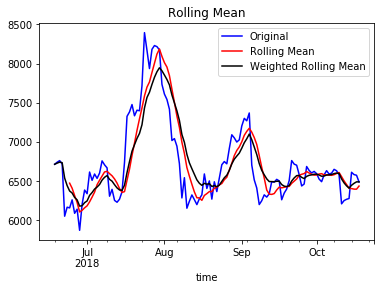

In [5]:
draw_trend(ts['2018-06-18':'2018-10-18'],7)
# weighted rolling window is more flat and stationary

In [6]:
# not Stationarity
testStationarity(ts)

Test Statistic                   -1.922454
p-value                           0.321573
#Lags Used                       23.000000
Number of Observations Used    1977.000000
Critical Value (1%)              -3.433662
Critical Value (5%)              -2.863003
Critical Value (10%)             -2.567549
dtype: float64

# Log

In [7]:
ts_log = np.log(ts)
testStationarity(ts_log)
# not stationary

Test Statistic                   -1.241086
p-value                           0.655677
#Lags Used                       17.000000
Number of Observations Used    1983.000000
Critical Value (1%)              -3.433652
Critical Value (5%)              -2.862999
Critical Value (10%)             -2.567547
dtype: float64

# Differnece

In [8]:
ts_log_diff = ts_log.diff(1).dropna()
testStationarity(ts_log_diff)
# Stationary

Test Statistic                -1.057704e+01
p-value                        7.061855e-19
#Lags Used                     1.600000e+01
Number of Observations Used    1.983000e+03
Critical Value (1%)           -3.433652e+00
Critical Value (5%)           -2.862999e+00
Critical Value (10%)          -2.567547e+00
dtype: float64

- Okay to difference 1.

# Draw acf & pcaf

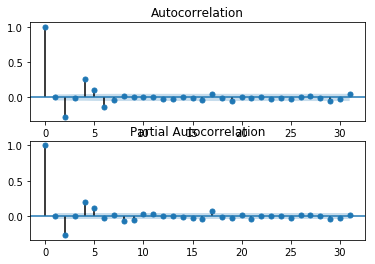

In [9]:
draw_acf_pacf(ts_log_diff, lags=31)

**p=1,3, q=1,3**

# Split train and test data

In [10]:
from datetime import datetime,timedelta
import pandas as pd
date = datetime(year=2018, month=6, day=18)
date_test = date+timedelta(days=6)

In [11]:
dataset = ts[:date]
validation = ts[date:date_test]
validation = pd.DataFrame(validation)

# Build Model

AIC = 2k - 2ln(L)
- k: Numbers of parameters
- L: Likelihood function

In [12]:
import warnings
warnings.simplefilter("ignore")

# other tool: itertools
from statsmodels.tsa.arima_model import ARIMA
for i in [1,3]:
    for j in [1,3]:
        try:
            mod = ARIMA(ts_log,order=(i,1,j))
            results = mod.fit()
            print('ARIMA {}x{} - AIC:{}'.format(i, j, results.aic))
        except:
            continue

ARIMA 1x1 - AIC:-5351.18568674263
ARIMA 1x3 - AIC:-5489.1694547676525
ARIMA 3x1 - AIC:-5512.846475037559
ARIMA 3x3 - AIC:-5588.4167282865055


**（3，1，3）is the best combo**

- forecast

In [13]:
# multi-step out-of-sample forecast
forecast = results.forecast(steps=7)[0]
forecast

array([8.52771772, 8.5281163 , 8.49776314, 8.48344474, 8.49634252,
       8.51121255, 8.51083513])

In [14]:
# 对数还原
forecast = np.exp(forecast)
# log_recover.dropna(inplace=True)

In [15]:
forecast.size

7

In [16]:
forecast = pd.DataFrame(forecast)
forecast['time'] = validation.index
forecast = forecast.set_index('time')
forecast.columns = ['prediction']

- predict

In [20]:
predict = results.predict(start = dataset.index[-1],end = validation.index[-1])
predict

2018-06-18    0.005146
2018-06-19    0.005236
2018-06-20   -0.006703
2018-06-21    0.001035
2018-06-22    0.006828
2018-06-23    0.010811
2018-06-24    0.026567
Freq: D, dtype: float64

In [37]:
# 根据ARIMA.predict(params, start=None, end=None, exog=None, typ='linear', dynamic=False)写的啊，不对诶。
predict_test = mod.predict(ts_log,start = dataset.index[-1],end = validation.index[-1])
predict_test

array([nan, nan, nan, nan, nan, nan, nan])

In [21]:
diff_sum = predict.cumsum()

In [22]:
# 先反差分
predict_versediff = np.log(dataset[-1]) + diff_sum
# 求log之前的值
predict_verse_log = np.exp(predict_versediff)
predict_verse_log

2018-06-18    6749.464297
2018-06-19    6784.899186
2018-06-20    6739.574822
2018-06-21    6746.555827
2018-06-22    6792.780912
2018-06-23    6866.617615
2018-06-24    7051.484757
Freq: D, dtype: float64

In [29]:
from sklearn.metrics import mean_squared_error
def plot_comparision(true, predict,preds):
    fig, ax = plt.subplots(1, figsize=(6, 4))
    x_date = [i for i in true.index]
    ax.plot(x_date,predict,color='blue', label='Forecast')
    ax.plot(x_date,true,color='red', label='Original')
    ax.plot(x_date,preds,color='green', label='Predict')
    plt.legend(loc='best')
    plt.xticks(rotation=60)
    plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(predict.values,true.values))+'\n'+
             'predict RMSE: %.4f'% np.sqrt(mean_squared_error(preds.values,true.values)))
    plt.show()

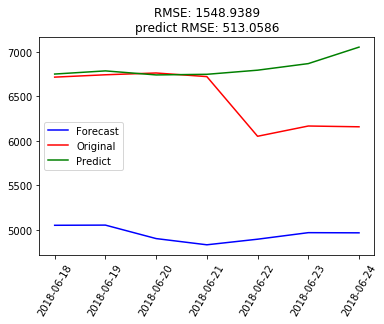

In [31]:
plot_comparision(validation, forecast,predict_verse_log)

### Conclusion： RMSE比LSTM大很多

In [32]:
?forecast

In [33]:
?predict

### Conclusion：
- 查了很多predict和forecast的区别，资料不多，都说差不多，但我这边的结果说明他们是不一样的。而且predict出来的结果需要自己差分回去，forecast则不需要
- **forecast:**
- ARMAResults.forecast(steps=1, exog=None, alpha=0.05)
- Returns:Out-of-sample forecasts
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

- **predict**
- ARIMA.predict(params, start=None, end=None, exog=None, typ='linear', dynamic=False)
- Returns:ARIMA model in-sample and out-of-sample prediction

- **Conclusion**
- ARIMA预测的结果都很平稳，而Bitcoin价格则很valotile，所以ARIMA模型的RMSE大。
- 用log处理过的数据，预测结果更准确。